<h2>HW #5</h2>
Matt Buchovecky
Astro 283

In [1]:
import numpy as np
from matplotlib import pyplot
%matplotlib inline 
from scipy import stats, special


<h2> Problem 1 </h2>

$$p\left(x\mid \alpha,\beta\right) = \left\{
\begin{array}{ll} 
 \alpha^{-1}\exp{\left(-\frac{x+\beta}{\alpha}\right)I_0\left(\frac{2\sqrt{x\beta}}{\alpha}\right)} & \quad \quad x\geq 0 \\
0 & \quad \quad x<0 \\
\end{array}
\right.
$$

In [2]:
class Rice_dist(stats.rv_continuous):
    "Rice distribution class"
        
    def _pdf(self, x, alpha, beta):
        return (1/alpha)*np.exp((x+beta)/(-alpha))*special.iv(0, 2*np.sqrt(x*beta)/alpha)


In [59]:
rice_inst = Rice_dist(a=0.0, name='Rice name') # b=inf

alpha, beta = (7., 47.)
mean_x = alpha + beta 
variance_x = alpha**2 + 2*alpha*beta

rice_trials_array = rice_inst.rvs(alpha=alpha, beta=beta, size=500)


162.6114823390682

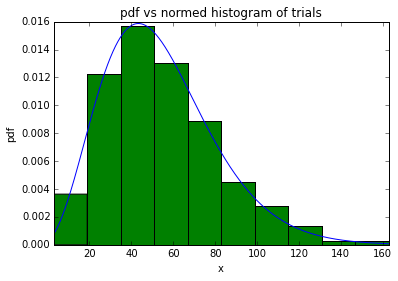

In [61]:
x = np.arange(rice_trials_array.min(), rice_trials_array.max(), 0.1)
p = pyplot.plot(x, rice_inst._pdf(x, alpha, beta))
h = pyplot.hist(rice_trials_array, normed=True)
pyplot.xlabel('x')
pyplot.ylabel('pdf')
pyplot.title("pdf vs normed histogram of trials")
pyplot.xlim(rice_trials_array.min(), rice_trials_array.max())
rice_trials_array.max()

In [18]:
outfile = open("./buchovecky_matt_hw5_data.txt", 'w')
for trial in np.nditer(rice_trials_array):
    outfile.write(str(trial)+'\n')
outfile.close()

In [11]:
print(mean_x)
print(rice_inst.expect(args=(alpha,beta)))
print(variance_x)
print(rice_inst.var(alpha=alpha, beta=beta))


60.0
59.99999999999999
1100.0
1100.00000004


<h2> Problem 2 </h2>

In [21]:
infile = open("./hw5-data.txt", 'r')
x_arr = [ ]
y_arr = [ ] 
sigma_arr = [ ] 

for line in iter(infile):
    line = line.split()
    try:
        float(line[0]) and float(line[1]) and float(line[2])
        x_arr.append(float(line[0]))
        y_arr.append(float(line[1]))
        sigma_arr.append(float(line[2]))
    except ValueError:
        continue
    
infile.close()

print(x_arr)
print(y_arr)
print(sigma_arr)

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
[3.46, 3.59, 4.19, 4.82, 7.02, 6.3, 6.11, 5.76, 8.47, 10.89]
[0.99, 1.0, 0.95, 0.74, 1.03, 1.07, 1.0, 0.99, 0.86, 0.61]


In [22]:
def poly_2nd_ord(x, a0, a1, a2):
    return a0 + a1*x + a2*x**2

def poly_3rd_ord(x, a0, a1, a2, a3):
    return a0 + a1*x + a2*x**2 + a3*pow(x,3)


In [ ]:
def rand_rejection(f, g_rand, a, b):
    u_rand = np.random.uniform(0, 1)
    M = 
    

In [62]:
np.prod?